In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Был выбран дата сет прогнозирования оттока клиентов
# Получим данный датасет
DF = pd.read_csv('/content/test.csv', delimiter = ',')
DF

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,746,GA,130,area_code_415,no,no,0,119.4,99,20.30,226.3,97,19.24,202.7,111,9.12,11.3,7,3.05,0
746,747,WA,73,area_code_408,no,no,0,177.2,118,30.12,270.5,84,22.99,241.8,112,10.88,12.3,2,3.32,3
747,748,WV,152,area_code_415,no,no,0,184.2,90,31.31,256.8,73,21.83,213.6,113,9.61,14.7,2,3.97,3
748,749,DC,61,area_code_415,no,no,0,140.6,89,23.90,172.8,128,14.69,212.4,97,9.56,13.6,4,3.67,1


In [ ]:
DF.columns

Index(['id', 'state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')

Проанализировав колонки в данном датасете можно сделать вывод, что для прогнозирования оттока клиентов данное количество информации избыточно для нас.

Из данного датасета возьмем только общее количество звонков и сообщений за день, вечер и тд.

In [ ]:
DF = DF[["number_vmail_messages","total_day_calls", "total_eve_calls", "total_night_calls", "total_intl_calls", "number_customer_service_calls"]]
DF

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,25,110,99,91,3,1
1,0,98,101,118,6,0
2,0,70,76,99,6,4
3,0,114,111,121,3,3
4,0,76,112,115,5,3
...,...,...,...,...,...,...
745,0,99,97,111,7,0
746,0,118,84,112,2,3
747,0,90,73,113,2,3
748,0,89,128,97,4,1


In [ ]:
# Проверим, есть ли пропуски
DF.columns[DF.isna().any()].tolist()

[]

In [ ]:
# Посчитаем число категориальных и числовых колонок
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))


categorical columns:	  [] 
 len =  0
numerical columns:	  ['number_vmail_messages', 'total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls', 'number_customer_service_calls'] 
 len =  6


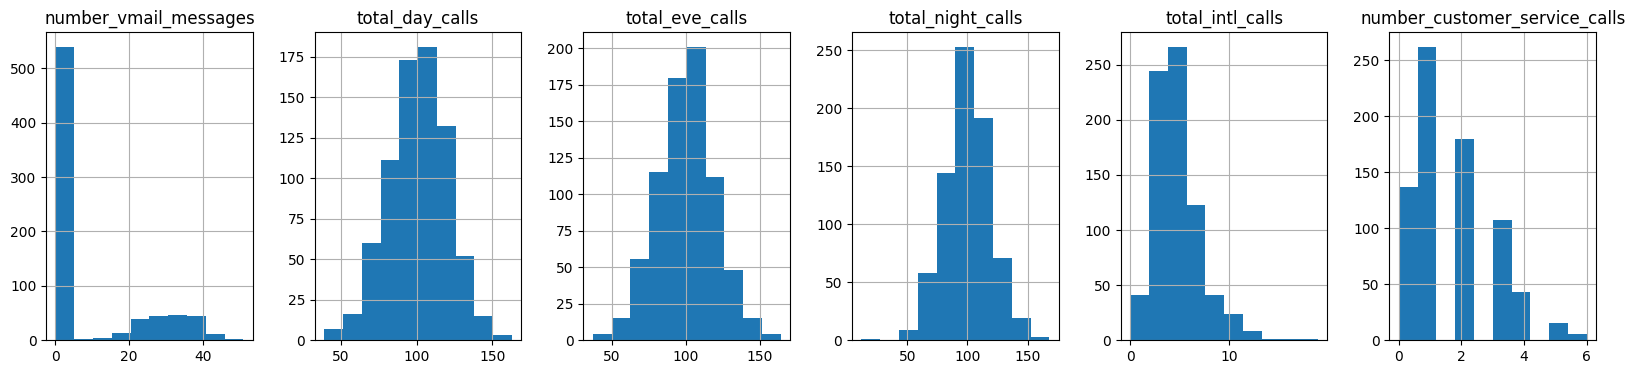

In [ ]:
#Выведем графики
fig, axs = plt.subplots(1,6,figsize=(20,  4))

DF.hist(column = num_columns, ax = axs);

На графиках видно что 2-5 колонки условно нормальные.
В первой колонке можно подрезать редкие значения.
Последнюю колонку, думаю можно нелинейно преобразовать



In [ ]:
# Стандартизация

#найдем среднее значение и стандартное отклонение
scale = StandardScaler()
scale.fit(DF[num_columns]);
scale.mean_, scale.scale_

(array([  8.45466667, 100.72133333, 100.27333333, 100.37066667,
          4.48533333,   1.63466667]),
 array([14.1142934 , 19.70538873, 19.35461932, 19.17244393,  2.42028612,
         1.27535546]))

In [ ]:
# применяем трансформацию .transform
scaled = scale.transform(DF[num_columns])
df_standard = pd.DataFrame(scaled, columns= num_columns)
df_standard

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,1.172240,0.470870,-0.065790,-0.488757,-0.613702,-0.497639
1,-0.599015,-0.138101,0.037545,0.919514,0.625821,-1.281734
2,-0.599015,-1.559032,-1.254136,-0.071491,0.625821,1.854646
3,-0.599015,0.673860,0.554217,1.075989,-0.613702,1.070551
4,-0.599015,-1.254547,0.605885,0.763040,0.212647,1.070551
...,...,...,...,...,...,...
745,-0.599015,-0.087353,-0.169124,0.554407,1.038996,-1.281734
746,-0.599015,0.876850,-0.840798,0.606565,-1.026876,1.070551
747,-0.599015,-0.544081,-1.409138,0.658723,-1.026876,1.070551
748,-0.599015,-0.594829,1.432561,-0.175808,-0.200527,-0.497639


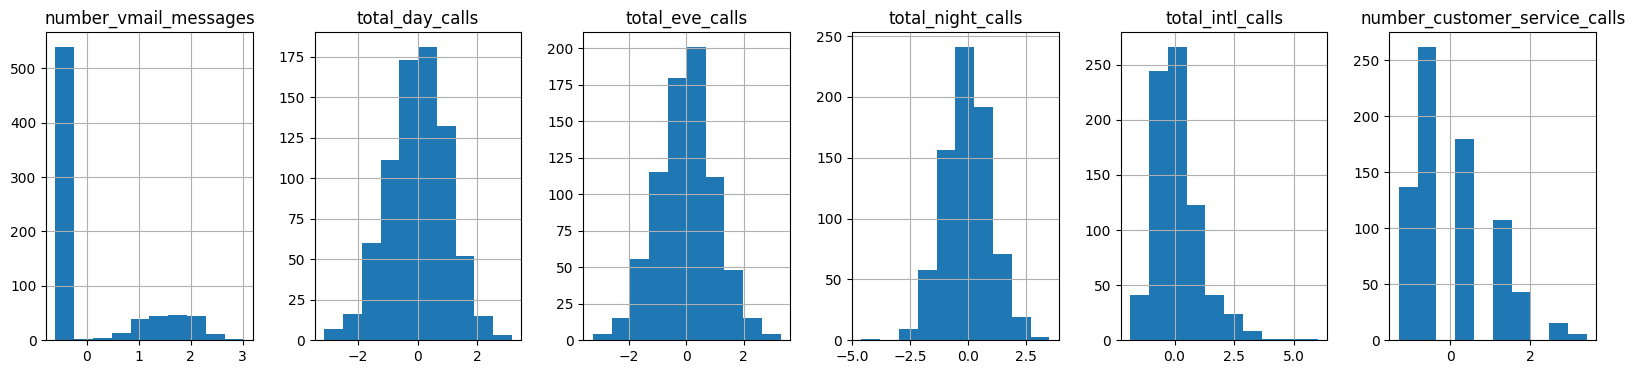

In [ ]:
df_standard.hist(figsize = (20,4), layout= (1,6));

In [ ]:
# Нормализация

# Найдем максимальное и минимальное значения для каждого из принаков
norm = MinMaxScaler()
norm.fit(DF[num_columns]);
norm.data_max_, norm.data_min_

(array([ 51., 163., 164., 168.,  19.,   6.]),
 array([ 0., 39., 37., 12.,  0.,  0.]))

In [ ]:
normolized = norm.transform(DF[num_columns])
df_norm = pd.DataFrame(normolized, columns= num_columns)
df_norm

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,0.490196,0.572581,0.488189,0.506410,0.157895,0.166667
1,0.000000,0.475806,0.503937,0.679487,0.315789,0.000000
2,0.000000,0.250000,0.307087,0.557692,0.315789,0.666667
3,0.000000,0.604839,0.582677,0.698718,0.157895,0.500000
4,0.000000,0.298387,0.590551,0.660256,0.263158,0.500000
...,...,...,...,...,...,...
745,0.000000,0.483871,0.472441,0.634615,0.368421,0.000000
746,0.000000,0.637097,0.370079,0.641026,0.105263,0.500000
747,0.000000,0.411290,0.283465,0.647436,0.105263,0.500000
748,0.000000,0.403226,0.716535,0.544872,0.210526,0.166667


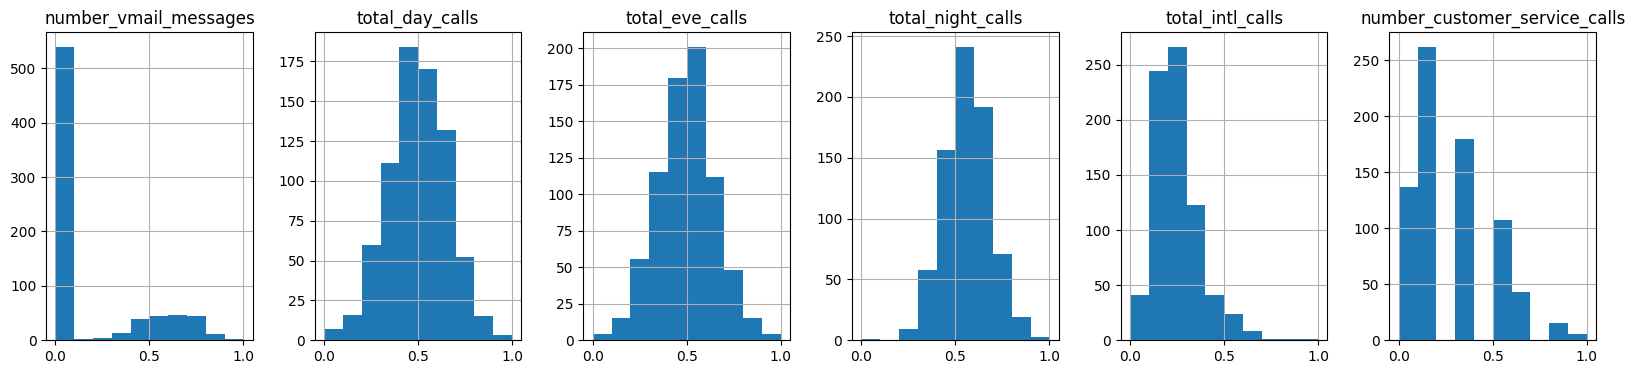

In [ ]:
df_norm.hist(figsize = (20,4), layout= (1,6));

In [ ]:
# Степенное преобразование

pt = PowerTransformer()

pt.fit(DF[num_columns]);
pt.lambdas_

array([-0.87815259,  1.12826062,  1.03584489,  1.07721166,  0.09868902,
        0.2312318 ])

In [ ]:
power = pt.transform(DF[num_columns])
df_power = pd.DataFrame(power, columns= num_columns)
df_power

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,1.586157,0.462304,-0.069322,-0.495315,-0.541369,-0.359602
1,-0.625564,-0.151030,0.034079,0.919533,0.772654,-1.588312
2,-0.625564,-1.543251,-1.252699,-0.079071,0.772654,1.598414
3,-0.625564,0.668695,0.552148,1.078391,-0.541369,1.082702
4,-0.625564,-1.250034,0.604049,0.760984,0.403424,1.082702
...,...,...,...,...,...,...
745,-0.625564,-0.100267,-0.172648,0.550078,1.097067,-1.588312
746,-0.625564,0.876008,-0.842360,0.602751,-1.189150,1.082702
747,-0.625564,-0.554715,-1.406191,0.655460,-1.189150,1.082702
748,-0.625564,-0.604864,1.436610,-0.183382,-0.026093,-0.359602


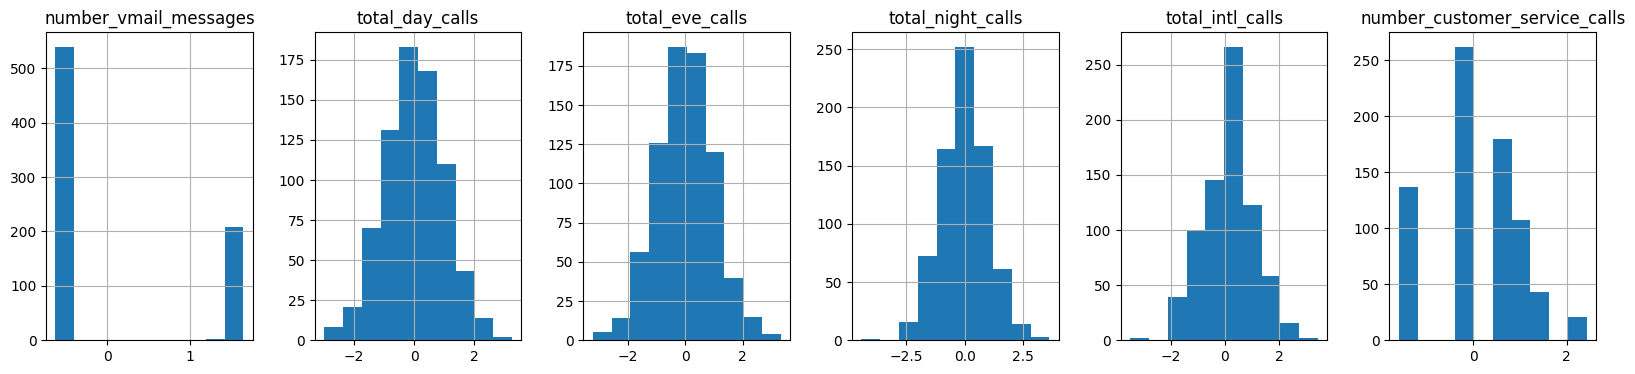

In [ ]:
df_power.hist(figsize = (20,4), layout= (1,6));

In [ ]:
# Статистика числовых значений
DF.describe()

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,8.454667,100.721333,100.273333,100.370667,4.485333,1.634667
std,14.123712,19.718539,19.367535,19.185238,2.421901,1.276207
min,0.000000,39.000000,37.000000,12.000000,0.000000,0.000000
25%,0.000000,88.000000,87.000000,88.000000,3.000000,1.000000
50%,0.000000,101.000000,101.000000,100.500000,4.000000,1.000000
75%,21.000000,114.000000,113.000000,113.000000,6.000000,2.000000
max,51.000000,163.000000,164.000000,168.000000,19.000000,6.000000


In [ ]:
# Класс определяет относительное пороговое значение для идентификации редких числовых значений.

class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
qr = QuantileReplacer(threshold=0.01, )
qr.fit(DF[num_columns])
DF_num_rare = qr.transform(DF[num_columns])
DF_num_rare.describe()

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,8.428000,99.744693,101.142200,99.680000,4.494667,1.626667
std,14.053285,19.350011,18.996881,18.565699,2.348047,1.251683
min,0.000000,53.470000,53.000000,58.000000,1.000000,0.000000
25%,0.000000,87.000000,88.000000,87.250000,3.000000,1.000000
50%,0.000000,100.500000,101.000000,100.000000,4.000000,1.000000
75%,21.000000,114.000000,113.000000,112.000000,6.000000,2.000000
max,43.000000,147.000000,146.510000,148.000000,12.000000,5.000000


In [ ]:
# Pipeline

# просто стандартизируем
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

num = ['total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls']

In [ ]:
num_pipe_vmail = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_vmail = ['number_vmail_messages']

In [ ]:
# Заменяем степенное преобразование
num_pipe_service_calls = Pipeline([
    ('power', PowerTransformer())
])

num_service_calls = ['number_customer_service_calls']

In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, num),
    ('number_vmail_messages', num_pipe_vmail, num_vmail),
    ('num_service_calls', num_pipe_service_calls, num_service_calls),
])

In [ ]:
preprocessors

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['total_day_calls', 'total_eve_calls',
                                  'total_night_calls', 'total_intl_calls']),
                                ('number_vmail_messages',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['number_vmail_messages']),
                                ('num_service_calls',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['number_customer_service_calls'])])

In [ ]:
preprocessors.fit(DF);

In [ ]:
preprocessors.transformers_

[('num_pipe',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['total_day_calls',
   'total_eve_calls',
   'total_night_calls',
   'total_intl_calls']),
 ('number_vmail_messages',
  Pipeline(steps=[('QuantReplace', QuantileReplacer(threshold=0.01)),
                  ('scaler', StandardScaler())]),
  ['number_vmail_messages']),
 ('num_service_calls',
  Pipeline(steps=[('power', PowerTransformer())]),
  ['number_customer_service_calls'])]

In [ ]:
preprocessors.transformers_[1]

('number_vmail_messages',
 Pipeline(steps=[('QuantReplace', QuantileReplacer(threshold=0.01)),
                 ('scaler', StandardScaler())]),
 ['number_vmail_messages'])

In [ ]:
preprocessors.transformers_[1][1]

Pipeline(steps=[('QuantReplace', QuantileReplacer(threshold=0.01)),
                ('scaler', StandardScaler())])

In [ ]:
preprocessors.transformers_[1][1]['QuantReplace']

QuantileReplacer(threshold=0.01)

In [ ]:
preprocessors.transformers_[2][1]

Pipeline(steps=[('power', PowerTransformer())])

In [ ]:
preprocessors.transformers_[2][1]['power'].get_feature_names_out(num_service_calls)

array(['number_customer_service_calls'], dtype=object)

In [ ]:
DF_transformed = preprocessors.transform(DF)
pd.DataFrame(DF_transformed, columns=DF.columns)

,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,0.470870,-0.065790,-0.488757,-0.613702,1.180013,-0.359602
1,-0.138101,0.037545,0.919514,0.625821,-0.600118,-1.588312
2,-1.559032,-1.254136,-0.071491,0.625821,-0.600118,1.598414
3,0.673860,0.554217,1.075989,-0.613702,-0.600118,1.082702
4,-1.254547,0.605885,0.763040,0.212647,-0.600118,1.082702
...,...,...,...,...,...,...
745,-0.087353,-0.169124,0.554407,1.038996,-0.600118,-1.588312
746,0.876850,-0.840798,0.606565,-1.026876,-0.600118,1.082702
747,-0.544081,-1.409138,0.658723,-1.026876,-0.600118,1.082702
748,-0.594829,1.432561,-0.175808,-0.200527,-0.600118,-0.359602
